In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window
from dataprep.eda import plot

In [2]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

## Schema Set

In [3]:
input = 'EDS_3.csv'
# Defining the schema for Lift1 datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

## Initial Filter to obtain useful Data. Others are useless with no anomalies or trends

In [4]:
# Selecting time range from 07/09 to 08/09 . Other data are useless. Here X is the column for accelerator
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,X as Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

## Standard Scaling - Z normalization

In [5]:
# The below code is to apply a standard scale to achieve Z normalization. This will ensure to make mean as 0 and standard deviation as 1.
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|0.964844| 0.326979|
|2018-07-09 12:00:...|0.957031|-0.094484|
|2018-07-09 12:00:...|0.949219|-0.515892|
|2018-07-09 12:00:...|0.949219|-0.515892|
|2018-07-09 12:00:...|0.957031|-0.094484|
|2018-07-09 12:00:...| 0.96875| 0.537683|
|2018-07-09 12:00:...|0.964844| 0.326979|
|2018-07-09 12:00:...|0.949219|-0.515892|
|2018-07-09 12:00:...|0.960938| 0.116275|
|2018-07-09 12:00:...|0.984375| 1.380554|
|2018-07-09 12:00:...|0.980469|  1.16985|
|2018-07-09 12:00:...|0.957031|-0.094484|
|2018-07-09 12:00:...|0.941406|-0.937355|
|2018-07-09 12:00:...|0.945313|-0.726596|
|2018-07-09 12:00:...|0.960938| 0.116275|
|2018-07-09 12:00:...| 0.96875| 0.537683|
|2018-07-09 12:00:...|0.957031|-0.094484|
|2018-07-09 12:00:...|0.957031|-0.094484|
|2018-07-09 12:00:...|0.957031|-0.094484|
|2018-07-09 12:00:...|0.953125|-0.305188|
+--------------------+--------+---

## Exploratory Findings

In [6]:
# Below code is to find the peak values. These could be possible anomalies
scaledData.sort(desc("Zscale")).show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-27 07:33:...|1.453125|26.666685|
|2018-07-10 13:03:...|1.398438|23.716664|
|2018-07-31 12:59:...|1.363281|21.820163|
|2018-07-31 12:59:...|1.347656|20.977292|
|2018-08-06 16:44:...|1.269531|16.762937|
|2018-08-06 16:44:...|1.246094|15.498657|
|2018-07-26 08:31:...|1.238281|15.077195|
|2018-07-31 13:27:...|1.214844|13.812915|
|2018-07-31 13:17:...|1.210938|13.602211|
|2018-07-31 13:19:...|1.210938|13.602211|
|2018-07-31 13:27:...|1.210938|13.602211|
|2018-07-31 13:09:...|1.207031|13.391453|
|2018-07-31 12:59:...|1.207031|13.391453|
|2018-07-31 13:27:...|1.203125|13.180749|
|2018-07-26 08:31:...|1.195313| 12.75934|
|2018-07-31 13:09:...|1.183594|12.127173|
|2018-07-31 10:28:...|1.175781|11.705711|
|2018-07-31 13:17:...|1.171875|11.495007|
|2018-07-31 13:27:...|1.171875|11.495007|
|2018-07-31 13:09:...|1.167969|11.284302|
+--------------------+--------+---

In [118]:
# Below code is to find the lowest values. These could be possible anomalies
scaledData.sort("Zscale").show(100)

+--------------------+--------+----------+
|           timestamp|       Z|    Zscale|
+--------------------+--------+----------+
|2018-07-27 07:33:...|0.449219|-27.487765|
|2018-07-27 07:33:...|  0.5625|-21.376964|
|2018-07-20 20:08:...|0.574219|-20.744797|
|2018-07-31 13:09:...|0.648438|-16.741146|
|2018-07-31 13:14:...|  0.6875|-14.633996|
|2018-07-31 13:09:...|  0.6875|-14.633996|
|2018-07-31 13:09:...|0.691406|-14.423291|
|2018-07-31 13:10:...|0.691406|-14.423291|
|2018-07-31 13:12:...|0.695313|-14.212533|
|2018-07-31 13:14:...|0.699219|-14.001829|
|2018-07-31 13:10:...|0.703125|-13.791125|
|2018-08-07 11:52:...|0.703125|-13.791125|
|2018-07-31 13:11:...|0.703125|-13.791125|
|2018-07-31 13:14:...|0.703125|-13.791125|
|2018-07-31 13:14:...|0.703125|-13.791125|
|2018-07-31 13:12:...|0.707031| -13.58042|
|2018-07-31 13:10:...|0.707031| -13.58042|
|2018-07-31 13:14:...|0.707031| -13.58042|
|2018-07-31 13:09:...|0.707031| -13.58042|
|2018-07-31 13:12:...|0.710938|-13.369662|
|2018-07-31

In [8]:
#Below code is to find the disribution of values for the entire filtered time period. This might help in finding
#frequent normal cases
# Round the Zscale value to 0
scaledData.createOrReplaceTempView("scaledData")
scaledNorm = spark.sql("select timestamp,Z,Zscale,round(Zscale,0) as Zround from scaledData")
scaledNorm.show()
# Select only the rounded values
scaledNorm.createOrReplaceTempView("scaledNorm")
scaledNorm = spark.sql("select distinct(Zround),count(Zround) from scaledNorm group by Zround")
scaledNorm.show()
#%time temp_dist = scaledNorm.toPandas()

+--------------------+--------+---------+------+
|           timestamp|       Z|   Zscale|Zround|
+--------------------+--------+---------+------+
|2018-07-09 12:00:...|0.964844| 0.326979|   0.0|
|2018-07-09 12:00:...|0.957031|-0.094484|   0.0|
|2018-07-09 12:00:...|0.949219|-0.515892|  -1.0|
|2018-07-09 12:00:...|0.949219|-0.515892|  -1.0|
|2018-07-09 12:00:...|0.957031|-0.094484|   0.0|
|2018-07-09 12:00:...| 0.96875| 0.537683|   1.0|
|2018-07-09 12:00:...|0.964844| 0.326979|   0.0|
|2018-07-09 12:00:...|0.949219|-0.515892|  -1.0|
|2018-07-09 12:00:...|0.960938| 0.116275|   0.0|
|2018-07-09 12:00:...|0.984375| 1.380554|   1.0|
|2018-07-09 12:00:...|0.980469|  1.16985|   1.0|
|2018-07-09 12:00:...|0.957031|-0.094484|   0.0|
|2018-07-09 12:00:...|0.941406|-0.937355|  -1.0|
|2018-07-09 12:00:...|0.945313|-0.726596|  -1.0|
|2018-07-09 12:00:...|0.960938| 0.116275|   0.0|
|2018-07-09 12:00:...| 0.96875| 0.537683|   1.0|
|2018-07-09 12:00:...|0.957031|-0.094484|   0.0|
|2018-07-09 12:00:..

In [10]:
# Save the entire distribution stats to a csv file. 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time temp_dist = scaledNorm.toPandas()
temp_dist.to_csv('Lift3_dist.csv',index=False)

CPU times: user 33 ms, sys: 72.9 ms, total: 106 ms
Wall time: 1.82 s


In [24]:
# Try some plots using dataprep
#plot(temp_dist,'Zround','count(Zround)')
#plt.rcParams["figure.figsize"] = (10,3)
#temp_dist.plot(x ='Zround', y='count(Zround)', kind = 'bar')
#plt.title("Z value distribution")
#plt.xticks(rotation=90)

## Selection of time ranges to plot based on above EDA findings

In [119]:
# Select time ranges based on above analysis to extract that particular timeframe.
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Z,Zscale from scaledData where timestamp between '2018-07-13 11:27:00' and '2018-07-13 11:28:00'").cache()

In [120]:
# Conversion of timestamp string to timestamp type. This is for smoothing purpose
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()

In [121]:
#Obtain moving averages
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
movAvg.show()

+--------------------+--------+---------+-------------------+--------------------+
|           timestamp|       Z|   Zscale|         timestamp1|       movingAverage|
+--------------------+--------+---------+-------------------+--------------------+
|2018-07-13 11:27:...|0.957031|-0.094484|2018-07-13 11:27:52|           -0.094484|
|2018-07-13 11:27:...|0.957031|-0.094484|2018-07-13 11:27:52|           -0.094484|
|2018-07-13 11:27:...|0.957031|-0.094484|2018-07-13 11:27:52|           -0.094484|
|2018-07-13 11:27:...|0.957031|-0.094484|2018-07-13 11:27:52|-0.16471866666666668|
|2018-07-13 11:27:...|0.953125|-0.305188|2018-07-13 11:27:52|-0.16471866666666668|
|2018-07-13 11:27:...|0.957031|-0.094484|2018-07-13 11:27:52|-0.09446566666666667|
|2018-07-13 11:27:...|0.960938| 0.116275|2018-07-13 11:27:52|           -0.024231|
|2018-07-13 11:27:...|0.957031|-0.094484|2018-07-13 11:27:52| 0.11625666666666667|
|2018-07-13 11:27:...|0.964844| 0.326979|2018-07-13 11:27:52|-0.02423100000000...|
|201

In [122]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [123]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 22.5 ms, sys: 20.1 ms, total: 42.6 ms
Wall time: 227 ms


### Plots of Anomalies detected for Lift 1. 10 different anomalies are plotted here

### Anomaly 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

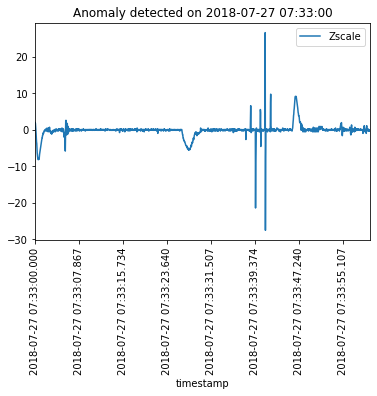

In [13]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 07:33:00")
plt.xticks(rotation=90)

### Anomaly 2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

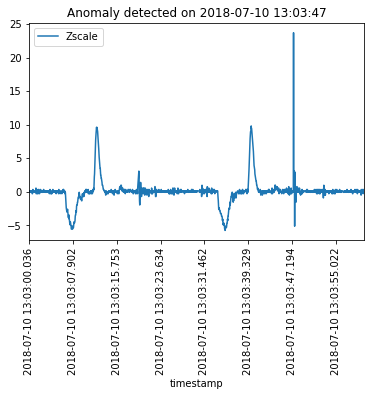

In [22]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-10 13:03:47")
plt.xticks(rotation=90)

### Anomaly 3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

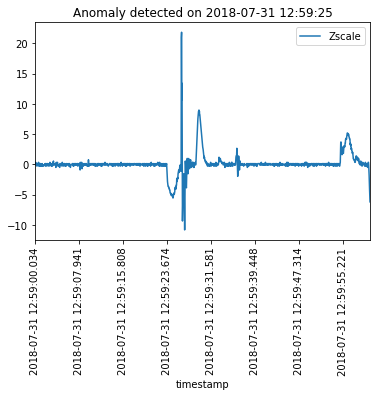

In [39]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 12:59:25")
plt.xticks(rotation=90)

### Anomaly 4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

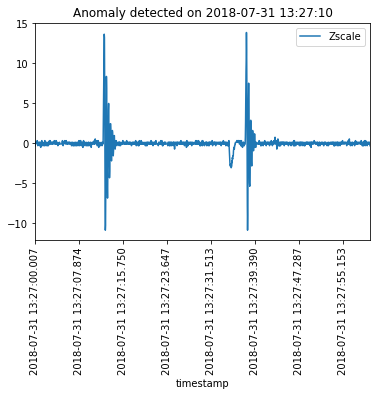

In [50]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 13:27:10")
plt.xticks(rotation=90)

### Anomaly 5

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

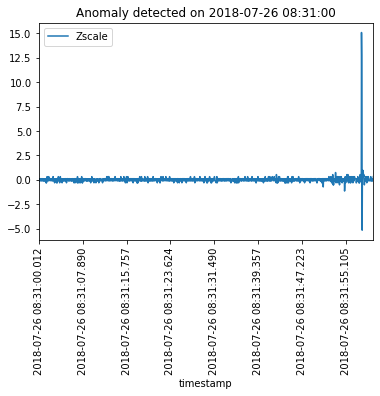

In [63]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-26 08:31:55")
plt.xticks(rotation=90)

### Anomaly 6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

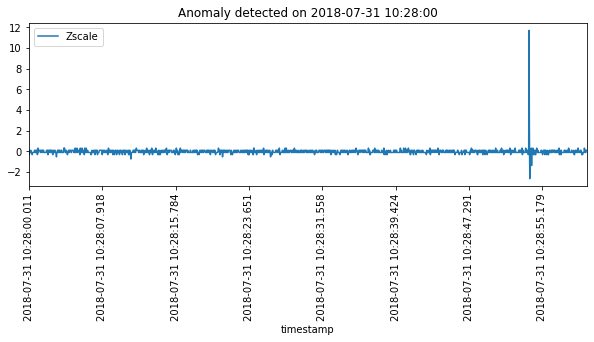

In [70]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 10:28:00")
plt.xticks(rotation=90)

### Anomaly 7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

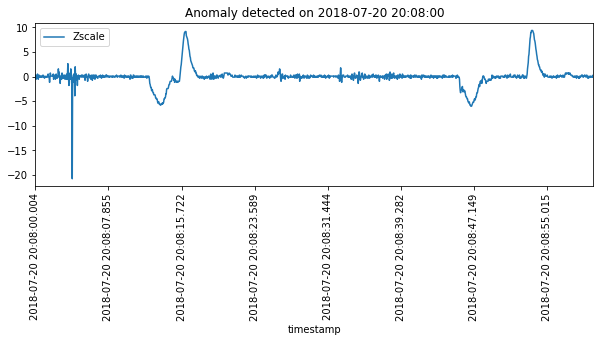

In [85]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-20 20:08:00")
plt.xticks(rotation=90)

### Anomaly 8

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

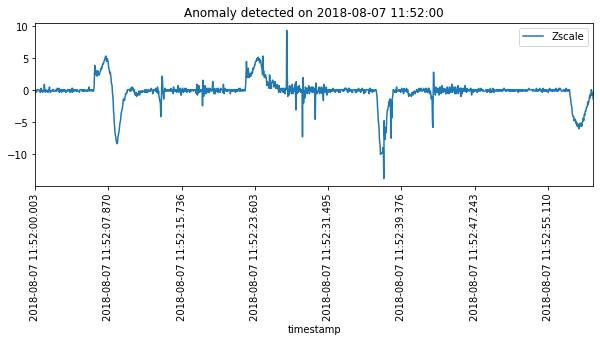

In [96]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-07 11:52:37")
plt.xticks(rotation=90)

### Anomaly 9

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

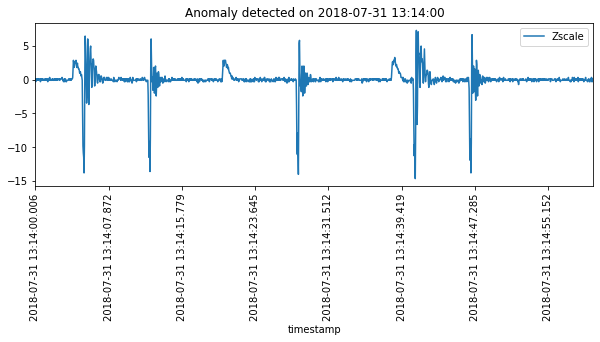

In [114]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 13:14:00")
plt.xticks(rotation=90)

### Anomaly 10

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

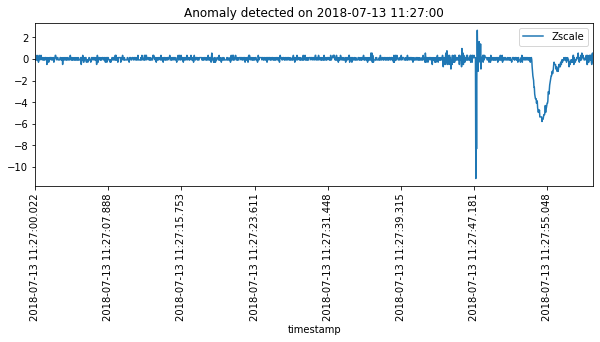

In [124]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 11:27:00")
plt.xticks(rotation=90)

## Plots after Smoothing

In [125]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 95.2 ms, sys: 76.7 ms, total: 172 ms
Wall time: 1.75 s


### Anomaly 1

(array([736902.31458333, 736902.31469907, 736902.31481481, 736902.31493056,
        736902.3150463 , 736902.31516204]),
 <a list of 6 Text xticklabel objects>)

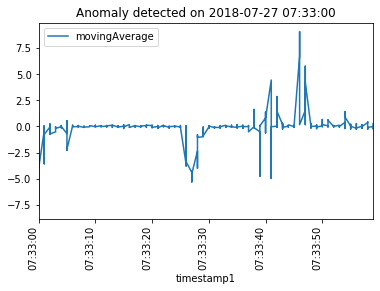

In [15]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 07:33:00")
plt.xticks(rotation=90)

### Anomaly 2

(array([736885.54375   , 736885.54386574, 736885.54398148, 736885.54409722,
        736885.54421296, 736885.5443287 ]),
 <a list of 6 Text xticklabel objects>)

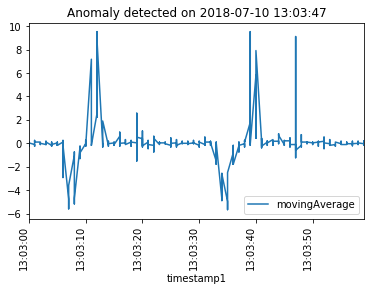

In [30]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-10 13:03:47")
plt.xticks(rotation=90)

### Anomaly 3

(array([736906.54097222, 736906.54108796, 736906.5412037 , 736906.54131944,
        736906.54143519, 736906.54155093]),
 <a list of 6 Text xticklabel objects>)

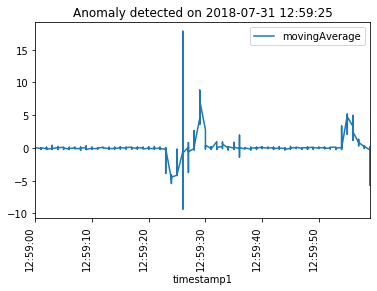

In [43]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 12:59:25")
plt.xticks(rotation=90)

### Anomaly 4

(array([736906.56041667, 736906.56053241, 736906.56064815, 736906.56076389,
        736906.56087963, 736906.56099537]),
 <a list of 6 Text xticklabel objects>)

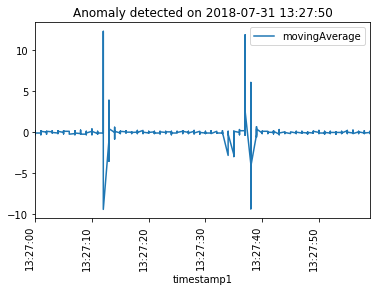

In [54]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 13:27:50")
plt.xticks(rotation=90)

### Anomaly 5

(array([736906.56041667, 736906.56053241, 736906.56064815, 736906.56076389,
        736906.56087963, 736906.56099537]),
 <a list of 6 Text xticklabel objects>)

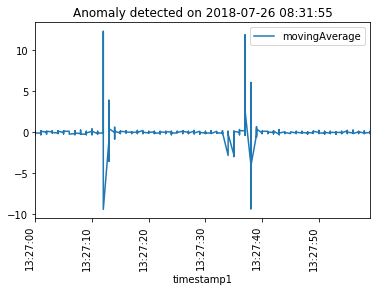

In [64]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-26 08:31:55")
plt.xticks(rotation=90)

### Anomaly 6

(array([736906.43611111, 736906.43622685, 736906.43634259, 736906.43645833,
        736906.43657407, 736906.43668981]),
 <a list of 6 Text xticklabel objects>)

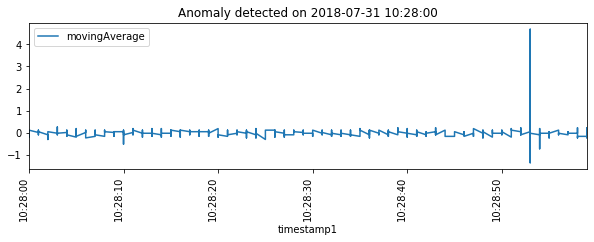

In [72]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 10:28:00")
plt.xticks(rotation=90)

### Anomaly 7

(array([736895.83888889, 736895.83900463, 736895.83912037, 736895.83923611,
        736895.83935185, 736895.83946759]),
 <a list of 6 Text xticklabel objects>)

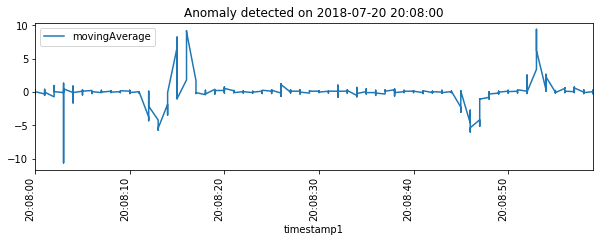

In [87]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-20 20:08:00")
plt.xticks(rotation=90)

### Anomaly 8

(array([736913.49444444, 736913.49456019, 736913.49467593, 736913.49479167,
        736913.49490741, 736913.49502315]),
 <a list of 6 Text xticklabel objects>)

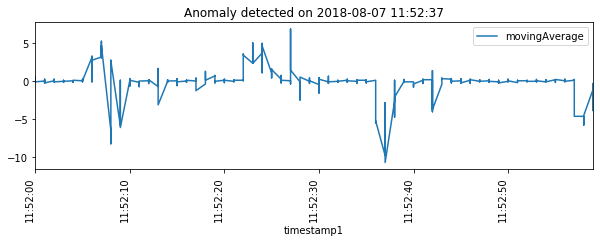

In [99]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-07 11:52:37")
plt.xticks(rotation=90)

### Anomaly 9

(array([736906.55138889, 736906.55150463, 736906.55162037, 736906.55173611,
        736906.55185185, 736906.55196759]),
 <a list of 6 Text xticklabel objects>)

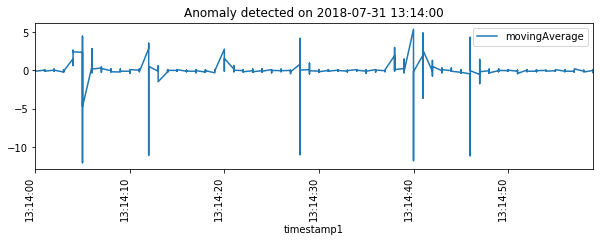

In [117]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 13:14:00")
plt.xticks(rotation=90)

### Anomaly 10

(array([736888.47708333, 736888.47719907, 736888.47731481, 736888.47743056,
        736888.4775463 , 736888.47766204]),
 <a list of 6 Text xticklabel objects>)

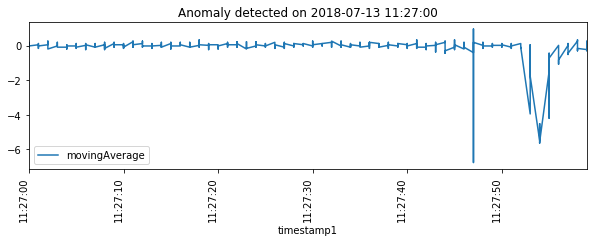

In [126]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 11:27:00")
plt.xticks(rotation=90)

## Finding Normal Patterns

In [127]:
scaledData.createOrReplaceTempView("scaledData")
scaledNorm = spark.sql("select timestamp,Z,Zscale,round(Zscale,0) as Zround from scaledData")
scaledNorm.createOrReplaceTempView("scaledNorm")
scaledfilt = spark.sql("select timestamp,Z,Zscale,Zround from scaledNorm where Zround >= 6 and Zround <= 6")
scaledfilt.show()

+--------------------+--------+--------+------+
|           timestamp|       Z|  Zscale|Zround|
+--------------------+--------+--------+------+
|2018-07-09 12:00:...|1.078125| 6.43778|   6.0|
|2018-07-09 12:00:...|1.066406|5.805614|   6.0|
|2018-07-09 12:01:...|1.070313|6.016372|   6.0|
|2018-07-09 12:01:...|1.070313|6.016372|   6.0|
|2018-07-09 12:01:...|1.070313|6.016372|   6.0|
|2018-07-09 12:01:...|1.070313|6.016372|   6.0|
|2018-07-09 12:01:...|1.066406|5.805614|   6.0|
|2018-07-09 12:01:...|  1.0625|5.594909|   6.0|
|2018-07-09 12:05:...|  1.0625|5.594909|   6.0|
|2018-07-09 12:05:...|  1.0625|5.594909|   6.0|
|2018-07-09 12:05:...|1.078125| 6.43778|   6.0|
|2018-07-09 12:05:...|1.074219|6.227076|   6.0|
|2018-07-09 12:05:...|1.070313|6.016372|   6.0|
|2018-07-09 12:06:...|1.074219|6.227076|   6.0|
|2018-07-09 12:06:...|1.078125| 6.43778|   6.0|
|2018-07-09 12:06:...|1.070313|6.016372|   6.0|
|2018-07-09 12:06:...|1.070313|6.016372|   6.0|
|2018-07-09 12:06:...|1.070313|6.016372|

In [140]:
temp_df = spark.sql("select timestamp,Z,Zscale from scaledData where timestamp between '2018-07-09 12:05:36' and '2018-07-09 12:07:34'").cache()
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 13.2 ms, sys: 20.3 ms, total: 33.5 ms
Wall time: 2.82 s


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text xticklabel objects>)

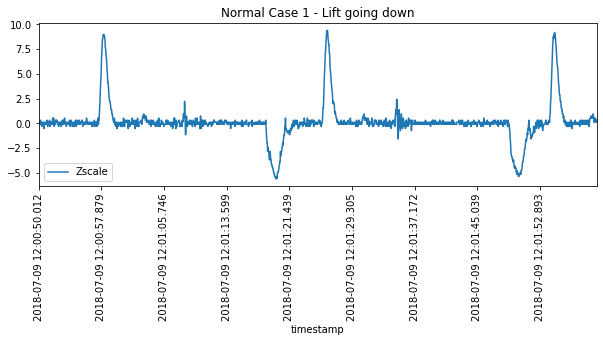

In [132]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal Case 1 - Lift going down")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text xticklabel objects>)

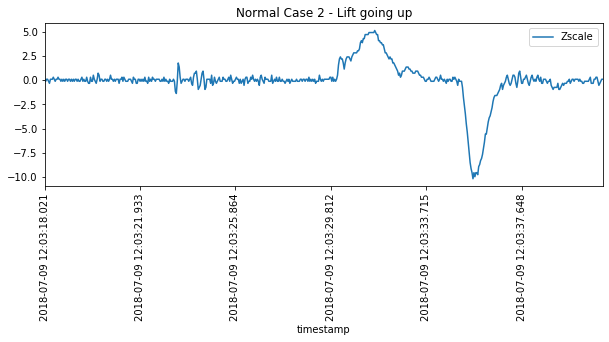

In [137]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal Case 2 - Lift going up")
plt.xticks(rotation=90)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]), <a list of 10 Text xticklabel objects>)

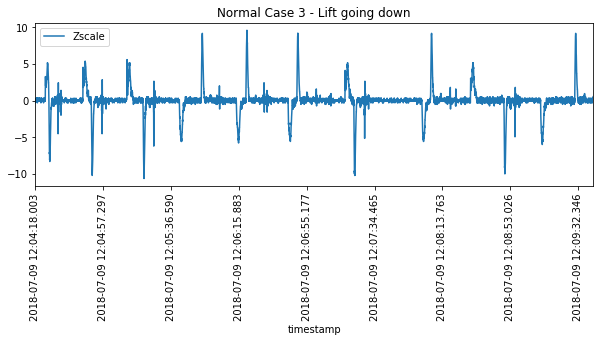

In [139]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal Case 3 - Lift going down")
plt.xticks(rotation=90)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 8 Text xticklabel objects>)

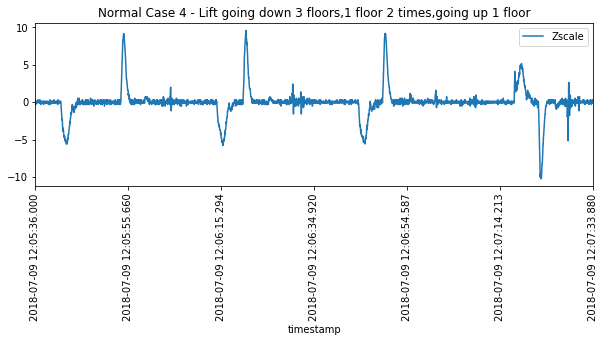

In [142]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal Case 4 - Lift going down 3 floors,1 floor 2 times,going up 1 floor")
plt.xticks(rotation=90)